## Note:
- Use ResNet-18 to test out since ResNet-18 requires least time to train
- ResNet-18 shows the worst performance in terms of the outliers present

## Trial 1:
- Apply Gaussian noise to fingerpritn images in the frequency domain
- Increase variance to 4*standard deviation for that channel, generate only 5 images per fingerprint
- Generated datasets: augmented_features_5_ue1_v1_ds, augmented_labels_5_ue1_v1_ds

In [5]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [6]:
from keras.models import Sequential
from keras.utils import np_utils

import h5py
import numpy as np
import math
import os
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow import keras

# from resnet import resnet18

In [7]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [8]:
# Get dictionary of class and reference point coordinates to calculate rmse later on

import h5py
import numpy as np
import tensorflow as tf

# Open HDF5 file and access the dataset
filename = 'dataset_SNR20_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

labels = np.array([i for i in range(3876)])

# Close the HDF5 file
hdf5_file.close()

# Currently, for features, have features from 3876 reference points, from 4 UEs, for (16,193) matrices
print(features_transposed.shape)
print(labels.shape)

(3876, 193, 16)
(3876,)


In [9]:
# Create custom callbacks to evaluate model
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, X_val, Y_val, cur_val_loss):
        super(ValidationCallback,self).__init__()
        self.X_val = X_val
        self.Y_val = Y_val
        self.cur_val_loss = cur_val_loss
        
    # number_of_iterations = total_number_of_training_examples / batch_size
    # In this case, train example of 1,000 and batch size of 100
    # number_of_iterations over 1 epoch is 10
    # if have 5 epochs, number of iterations is 50
    
    def calc_error(self, actual, predicted):

        x_error = (actual[0] - predicted[0])**2
        y_error = (actual[1] - predicted[1])**2
        z_error = (actual[2] - predicted[2])**2

        return x_error + y_error + z_error
        
    # Have one function that reports metrics on end of every epoch
    def on_epoch_end(self, epoch, logs = None):
        
        # Get evaluation metrics
        print('\n')
        print('Epoch End - Custom Validation Callback')
        val_loss, val_accuracy = self.model.evaluate(self.X_val, self.Y_val, verbose = 0)
        
        # Get distance error metrics - RMSE
        # Get predictions for each feature heatmap in X_val
        Y_pred = self.model.predict(self.X_val, verbose = 0)
        err_sum = 0
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(self.X_val)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[self.Y_val[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(Y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            err_sum += err
        rmse = np.sqrt((err_sum/len(self.X_val)))
       
        # Save values to log
        logs['val_loss'] = val_loss
        logs['val_accuracy'] = val_accuracy
        logs['rmse'] = rmse
        
        # Whenever validation loss is minimised and below threshold, save the model
        # and update current minimum loss
        if val_loss < self.cur_val_loss:
            self.model.save('resnet18_trial.h5')
            self.cur_val_loss = val_loss

In [10]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

features = np.load('augmented_features_5_ue1_agn_ds.npy')
labels = np.load('augmented_labels_5_ue1_agn_ds.npy')
X = features
y = labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [11]:
print(os.getcwd())
os.chdir('../resnet18')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/resnet18


In [12]:
import math
from resnet import resnet18
import time

class Model:
    
    def __init__(self):
        
        # Create model
        model_inputs = keras.Input(shape = (193, 16, 1))
        model_outputs = resnet18(model_inputs, num_classes = 3876)
        self.model = keras.Model(model_inputs, model_outputs)

        # Compile model - Classification
        # default learning rate is 1e-3 = 0.001
        self.model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
        
    def train_model(self):
    
        # In training, use model.fit() validation callback to get results on training loss, training accuracy,
        # validation loss and validation accuracy and rmse after every epoch
        val_callback = ValidationCallback(X_val, y_val, math.inf)
        
        # Can leave out early stopping for now, manually observe when val_loss stops improving to determine
        # optimal number of epochs
        # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
        hist = self.model.fit(X_train, y_train,
                              epochs = 100,
                              batch_size = 64,
                              callbacks = [val_callback]
#                              callbacks = [val_callback, stop_early]
                             )
        
        return hist
    
    def calc_error(self, actual, predicted):

            x_error = (actual[0] - predicted[0])**2
            y_error = (actual[1] - predicted[1])**2
            z_error = (actual[2] - predicted[2])**2

            return x_error + y_error + z_error
    
    def calc_errorcdf(self, errors):
        
        # Sort the array
        sorted_data = np.sort(errors)

        # Calculate cumulative probabilities
        n = len(sorted_data)
        cumulative_probs = np.arange(1, n + 1) / n
    
        return (sorted_data, cumulative_probs)
        
    def test_model(self, filename):
        
        # Load model
        self.model = keras.models.load_model(filename)
        
        # In test, use model.predict() to get the RMSE errors of predictions and CDF of distance error
        y_pred = self.model.predict(X_test, verbose = 0)
        err_sum = 0
        
        dist_errors = []
        max_disterror = -math.inf
        max_disterror_actual, max_disterror_pred = None, None
        
        # Iterate through actual and predicted to get distance error
        for i in range(len(X_test)):

            # Get the coordinates for actual y
            actual_coords = rp_dict[y_test[i]]
            
            # Get the coordinates for predicted y
            predicted_rp = np.argmax(y_pred[i])
            pred_coords = rp_dict[predicted_rp]

            # Calculate distance error
            err = self.calc_error(actual_coords, pred_coords)
            
            # Update the maximum errror, if needed
            dist_err = np.sqrt(err)
            if dist_err > max_disterror:
                
                # Update max error
                max_disterror = dist_err
                
                # Return the class index and then retrieve actual coordinates from rp_dict
                max_disterror_actual = y_test[i]
                max_disterror_pred = predicted_rp
            
            # Append error to distance errors
            dist_errors.append(dist_err)
            err_sum += err
            
        # Get RMSE of all predicted points
        rmse = np.sqrt((err_sum/len(X_test)))
        
        # Get actual and predicted point with the largest error
        print(f'Largest error: {max_disterror}, Actual RP index: {max_disterror_actual}, Predicted RP index: {max_disterror_pred}')
        
        return (rmse, *self.calc_errorcdf(dist_errors))
    
    def eval_model(self, filename):

        self.model = keras.models.load_model(filename)
        test_loss, test_acc = self.model.evaluate(X_test, y_test, batch_size = 64)

        return (test_loss, test_acc)

In [19]:
print(os.getcwd())
os.chdir('../data_augmentation')
print(os.getcwd())

/home/jovyan/committed_git/resnet18
/home/jovyan/committed_git/data_augmentation


In [13]:
resnet18_model = Model()
trg_results = resnet18_model.train_model()

2023-07-06 01:15:41.379829: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 01:15:41.919170: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 42007 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:25:00.0, compute capability: 8.6


Epoch 1/100


2023-07-06 01:15:44.646352: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-07-06 01:15:46.017595: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


265/265 [==============================] - ETA: 0s - loss: 7.1433 - accuracy: 0.0092

Epoch End - Custom Validation Callback
265/265 [==============================] - 11s 27ms/step - loss: 7.1433 - accuracy: 0.0092 - val_loss: 6.0628 - val_accuracy: 0.0224 - rmse: 7.2952
Epoch 2/100
265/265 [==============================] - ETA: 0s - loss: 5.4180 - accuracy: 0.0395

Epoch End - Custom Validation Callback
265/265 [==============================] - 5s 18ms/step - loss: 5.4180 - accuracy: 0.0395 - val_loss: 5.3487 - val_accuracy: 0.0497 - rmse: 5.7199
Epoch 3/100
263/265 [============================>.] - ETA: 0s - loss: 4.3087 - accuracy: 0.0897

Epoch End - Custom Validation Callback
265/265 [==============================] - 5s 18ms/step - loss: 4.3078 - accuracy: 0.0899 - val_loss: 4.0612 - val_accuracy: 0.1246 - rmse: 3.6807
Epoch 4/100
263/265 [============================>.] - ETA: 0s - loss: 3.3964 - accuracy: 0.1602

Epoch End - Custom Validation Callback
265/265 [=============

In [14]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

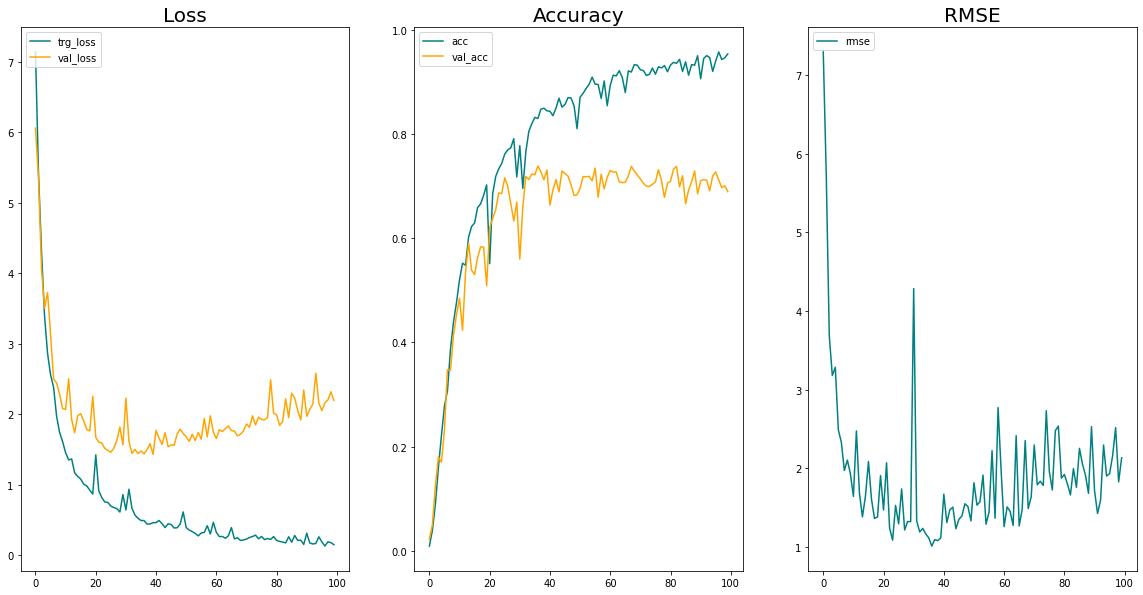

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='rmse')
axs[2].legend(loc='upper left')
axs[2].set_title('RMSE', fontsize=20)

plt.show()

In [16]:
val_loss = np.array(val_loss)
print(f'Minimum loss: {val_loss.min()}')
best_epoch = np.where(val_loss == val_loss.min())[0][0]

print(f'Best Epoch no: {best_epoch}')
print(f'Best val loss: {val_loss[best_epoch]}, Best val acc: {val_acc[best_epoch]}')
print(f'Best trg loss: {loss[best_epoch]}, Best trg acc: {acc[best_epoch]}')

Minimum loss: 1.428329348564148
Best Epoch no: 39
Best val loss: 1.428329348564148, Best val acc: 0.7309602499008179
Best trg loss: 0.4585936367511749, Best trg acc: 0.8447796702384949


In [20]:
# Test model
rmse, dist_errors, cdf_vals = resnet18_model.test_model("resnet18_trial.h5")

Largest error: 11.01135777277262, Actual RP index: 61, Predicted RP index: 5


In [21]:
print(rmse)

1.1172700116942442


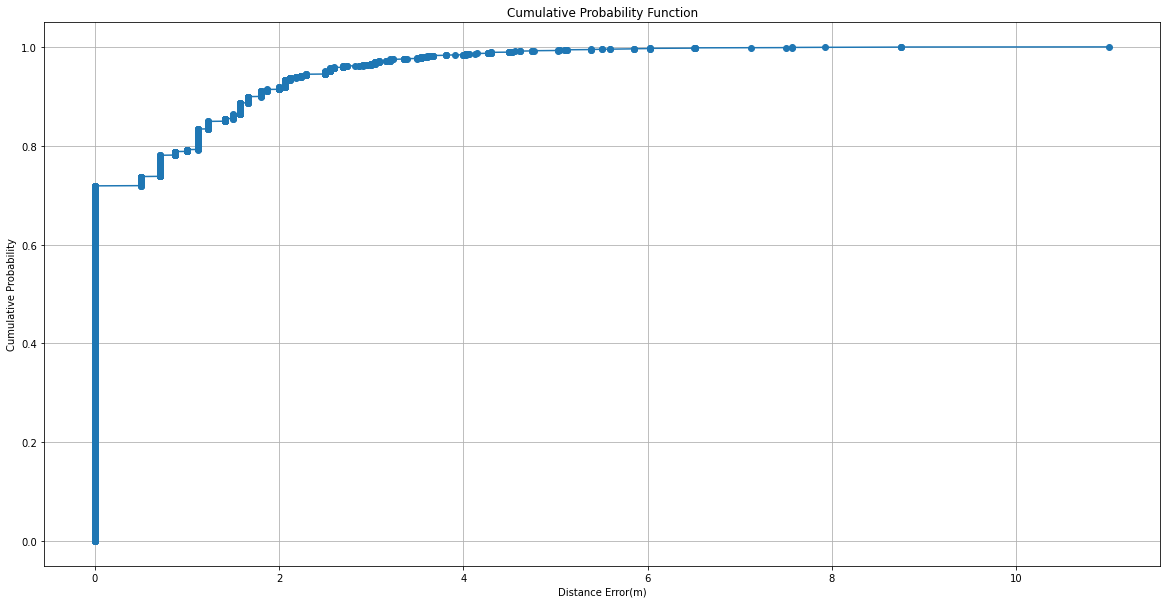

In [22]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()

## Observations:

- Dataset was not large enough resulting in larger difference between training and validation accuracy. (Signs of overfitting and more data is needed)
- Maximum error was reduced to 11m, suggesting that barrel rolling is a more gentle data augmentation method that did not cause two very different reference points to have a similar fingerprint

## Trial 2:
- Apply barrel rolling
- Barrel roll downwards at (40,80,120,160) and upwards at (30,60,90,120)
- Generated datasets: augmented_features_8_ue1_br_ds, augmented_labels_8_ue1_br_ds

In [26]:
print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [27]:
# from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

features = np.load('augmented_features_8_ue1_br_ds.npy')
labels = np.load('augmented_labels_8_ue1_br_ds.npy')
X = features
y = labels

# random_state = 42 to always ensure same split of dataset
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.125, random_state=42, shuffle = True)

In [28]:
print(os.getcwd())
os.chdir('../data_augmentation')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/data_augmentation


In [29]:
resnet18_model = Model()
trg_results = resnet18_model.train_model()

Epoch 1/100
1145/1145 [==============================] - ETA: 0s - loss: 5.2624 - accuracy: 0.1061

Epoch End - Custom Validation Callback
1145/1145 [==============================] - 20s 16ms/step - loss: 5.2624 - accuracy: 0.1061 - val_loss: 2.6044 - val_accuracy: 0.3152 - rmse: 3.3007
Epoch 2/100
1143/1145 [============================>.] - ETA: 0s - loss: 1.8459 - accuracy: 0.4751

Epoch End - Custom Validation Callback
1145/1145 [==============================] - 18s 16ms/step - loss: 1.8451 - accuracy: 0.4753 - val_loss: 1.2362 - val_accuracy: 0.6361 - rmse: 1.6555
Epoch 3/100
1142/1145 [============================>.] - ETA: 0s - loss: 1.0816 - accuracy: 0.6679

Epoch End - Custom Validation Callback
1145/1145 [==============================] - 18s 15ms/step - loss: 1.0815 - accuracy: 0.6680 - val_loss: 0.8973 - val_accuracy: 0.7147 - rmse: 1.3962
Epoch 4/100
1145/1145 [==============================] - ETA: 0s - loss: 0.8060 - accuracy: 0.7463

Epoch End - Custom Validation Cal

In [30]:
loss = trg_results.history['loss']
acc = trg_results.history['accuracy']
val_loss = trg_results.history['val_loss']
val_acc = trg_results.history['val_accuracy']
rmse = trg_results.history['rmse']
epochs = [i for i in range(len(rmse))]

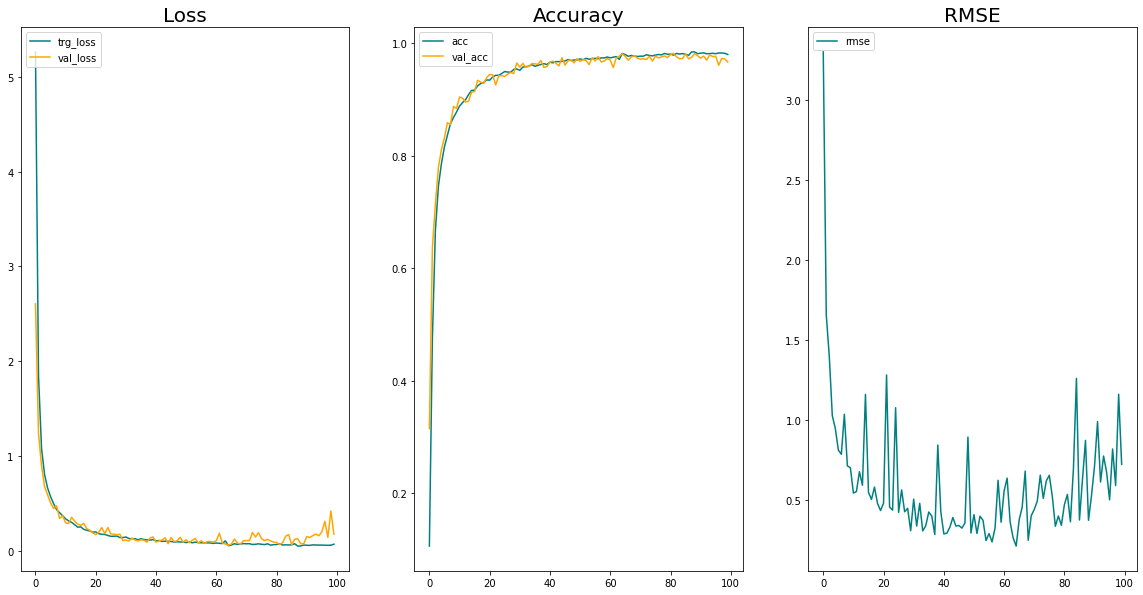

In [31]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].plot(epochs, loss, color='teal', label='trg_loss')
axs[0].plot(epochs, val_loss, color='orange', label='val_loss')
axs[0].legend(loc='upper left')
axs[0].set_title('Loss', fontsize=20)

axs[1].plot(epochs, acc, color='teal', label='acc')
axs[1].plot(epochs, val_acc, color='orange', label='val_acc')
axs[1].legend(loc='upper left')
axs[1].set_title('Accuracy', fontsize=20)

axs[2].plot(epochs, rmse, color='teal', label='rmse')
axs[2].legend(loc='upper left')
axs[2].set_title('RMSE', fontsize=20)

plt.show()

In [32]:
val_loss = np.array(val_loss)
print(f'Minimum loss: {val_loss.min()}')
best_epoch = np.where(val_loss == val_loss.min())[0][0]

print(f'Best Epoch no: {best_epoch}')
print(f'Best val loss: {val_loss[best_epoch]}, Best val acc: {val_acc[best_epoch]}')
print(f'Best trg loss: {loss[best_epoch]}, Best trg acc: {acc[best_epoch]}')

Minimum loss: 0.05763871967792511
Best Epoch no: 64
Best val loss: 0.05763871967792511, Best val acc: 0.9813682436943054
Best trg loss: 0.05257805064320564, Best trg acc: 0.981898844242096


In [33]:
# Test model
rmse, dist_errors, cdf_vals = resnet18_model.test_model("resnet18_trial.h5")

Largest error: 4.123105625617661, Actual RP index: 1857, Predicted RP index: 1781


In [34]:
print(rmse)

0.20302405380399866


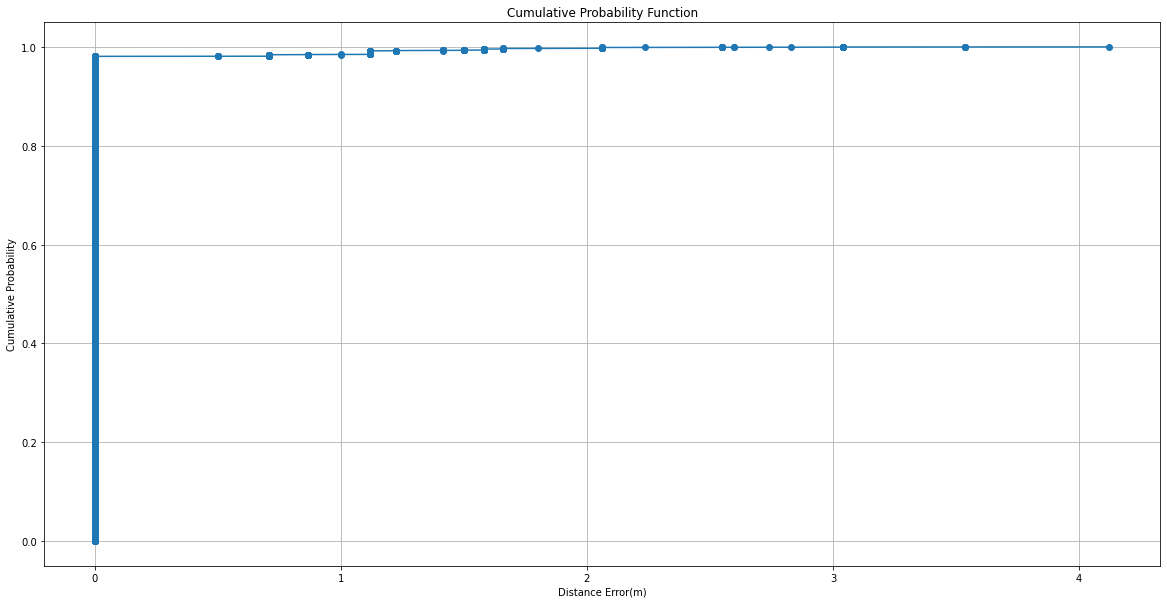

In [35]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

plt.plot(dist_errors, cdf_vals, marker='o')
plt.xlabel('Distance Error(m)')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Probability Function')
plt.grid(True)
plt.show()